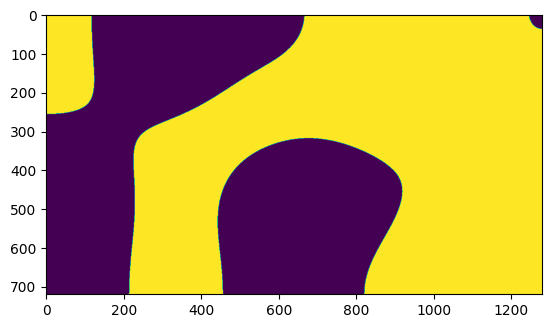

(720, 1280)

In [4]:
from utils import generate_cow_mask
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt


mask = generate_cow_mask((720,1280), 150, 0.5, 1)[0][0]
plt.imshow(mask)
plt.show()
mask.shape



In [8]:
import torch
x = torch.tensor([1,2,11,4,5,6,7,8,9,10])
sorted(x)[0].item()

1

In [1]:
import torch
from torch.utils.data import DataLoader
import albumentations as A
from datasets import GTA5, CityScapes
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from training import train
from model_evaluation import save_results
from visualization import  plot_loss, plot_mIoU, plot_IoU
from config import BATCH_SIZE, NC, NUM_WORKERS, CITYSCAPE_SIZE, GTA5_SIZE, EPOCHS, CITYSCAPES_MEAN, CITYSCAPES_STD, GTA5_MEAN, GTA5_STD
torch.cuda.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = BiSeNet(NC, 'resnet18').to(device)

def mix(mask, data = None, target = None):
    #Mix
    if not (data is None):
        if mask.shape[0] == data.shape[0]:
            data = torch.cat([(mask[i] * data[i] + (1 - mask[i]) * data[(i + 1) % data.shape[0]]).unsqueeze(0) for i in range(data.shape[0])])
        elif mask.shape[0] == data.shape[0] / 2:
            data = torch.cat((torch.cat([(mask[i] * data[2 * i] + (1 - mask[i]) * data[2 * i + 1]).unsqueeze(0) for i in range(int(data.shape[0] / 2))]),
                              torch.cat([((1 - mask[i]) * data[2 * i] + mask[i] * data[2 * i + 1]).unsqueeze(0) for i in range(int(data.shape[0] / 2))])))
    if not (target is None):
        target = torch.cat([(mask[i] * target[i] + (1 - mask[i]) * target[(i + 1) % target.shape[0]]).unsqueeze(0) for i in range(target.shape[0])])
    return data, target

def generate_class_mask(pred, classes):
    pred, classes = torch.broadcast_tensors(pred.unsqueeze(0), classes.unsqueeze(1).unsqueeze(2))
    N = pred.eq(classes).sum(0)
    return N




transforms = A.Compose([
    A.Resize(CITYSCAPE_SIZE[0], CITYSCAPE_SIZE[1]),
])
transforms_GTA5 = A.Compose([
        A.Resize(GTA5_SIZE[0], GTA5_SIZE[1]),


])

cityscapes_train_dataset = CityScapes('./Cityscapes', 'train', transform=transforms)
cityscapes_test_dataset = CityScapes('./Cityscapes', 'val', transform=transforms)
GTA5_dataset = GTA5('./GTA5', transform=transforms_GTA5)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, batch_size=2, shuffle=True, num_workers=NUM_WORKERS)
GTA5_dataloader = DataLoader(GTA5_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
# cityscapes_mean, city_scapes_std = calculate_mean_std(cityscapes_train_dataloader)
# GTA5_mean, GTA5_std = calculate_mean_std(GTA5_dataloader)

len(cityscapes_train_dataloader)

786

In [2]:
import numpy as np
for image, label in GTA5_dataloader:
    image, label = image.to(device), label.to(device)
    pred, _, _ = model(image)
    pred_soft = torch.argmax(torch.softmax(pred, dim=1), dim=1).long()
    masks = []
    for i in range(image.size(0)):  # Iterate over each image in the batch
        image_classes = torch.unique(pred_soft[i])
        image_classes = image_classes[image_classes != 255]  # Exclude the ignore class
        nclasses = image_classes.shape[0]
        selected_classes = image_classes[torch.Tensor(np.random.choice(nclasses, int((nclasses - nclasses % 2) / 2), replace=False)).long()].cuda()
        print(selected_classes)
        masks.append(generate_class_mask(pred_soft[i], selected_classes))
    mask = torch.stack(masks)
    print(mask.shape)
    break



tensor([ 6, 14,  4, 17, 13, 16,  5,  7], device='cuda:0')
tensor([ 4,  5,  8, 13, 16,  9,  0], device='cuda:0')
tensor([12,  5,  2, 14,  6,  7,  4, 16,  3], device='cuda:0')
tensor([14, 13, 17,  9, 11, 16,  6,  5], device='cuda:0')
torch.Size([4, 720, 1280])


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]], device='cuda:0')

In [21]:
del class_occurance_dict['255']


In [23]:
total_occurrences = sum(class_occurance_dict.values())
normalized_class_occurance_dict = {k: v / total_occurrences for k, v in class_occurance_dict.items()}
normalized_class_occurance_dict


{'0': 0.4736585289252789,
 '1': 0.037353923869027014,
 '2': 0.1389279692559401,
 '4': 0.007365253267702513,
 '5': 0.01239771468073813,
 '6': 0.0013794206725236096,
 '7': 0.001262954484359789,
 '8': 0.07425178751055177,
 '9': 0.033243068673944144,
 '10': 0.17447357014382447,
 '11': 0.0013711530365722823,
 '12': 0.0002874583073654686,
 '13': 0.02390354978900514,
 '14': 0.01303180359961868,
 '15': 0.002847960219900922,
 '16': 0.003787484910037849,
 '17': 0.00039483666786594736,
 '18': 6.156198574335419e-05}

In [26]:
normalized_class_occurance_dict

{'0': 0.4736585289252789,
 '1': 0.037353923869027014,
 '2': 0.1389279692559401,
 '4': 0.007365253267702513,
 '5': 0.01239771468073813,
 '6': 0.0013794206725236096,
 '7': 0.001262954484359789,
 '8': 0.07425178751055177,
 '9': 0.033243068673944144,
 '10': 0.17447357014382447,
 '11': 0.0013711530365722823,
 '12': 0.0002874583073654686,
 '13': 0.02390354978900514,
 '14': 0.01303180359961868,
 '15': 0.002847960219900922,
 '16': 0.003787484910037849,
 '17': 0.00039483666786594736,
 '18': 6.156198574335419e-05}

In [27]:
import numpy as np
np.random.choice(18, 9, replace=False, p=[normalized_class_occurance_dict[str(i)] for i in normalized_class_occurance_dict.keys()])


array([ 9,  0,  4,  2,  7, 13, 10,  1, 12])

In [13]:
np.array([6.2180e-01, 2.4328e-01, 6.5144e-01, 8.4728e-02, 7.5659e-02, 1.7496e-01,
        7.4601e-02, 6.3373e-02, 6.2709e-01, 7.3831e-02, 6.0504e-01, 2.3958e-01,
        2.1837e-02, 6.6673e-01, 1.2664e-01, 6.7213e-02, 1.6831e-02, 1.0683e-02,
        6.5719e-04]).mean()

0.23399858894736844

In [16]:
import numpy as np

text = "road: 30.50% sidewalk: 4.21% building: 61.14% wall: 5.81% fence: 2.34% pole: 15.27% traffic light: 13.24% traffic sign: 7.24% vegetation: 66.19% terrain: 3.18% sky: 58.31% person: 38.82% rider: 7.36% car: 47.89% truck: 1.52% bus: 0.30% train: 0.00% motorcycle: 3.09% bicycle: 0.00%"

# Extracting the percentage values
percentages = [float(value.split('%')[0]) for value in text.split() if '%' in value]

# Creating a NumPy array
percentages_array = np.array(percentages).mean()

print(percentages_array)

19.284736842105264


: 